In [3]:
# QubiC toolchain for compiling circuits
import qubic.toolchain as tc

# QubiC configuration management libraries
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs

# other packages
import numpy as np
import bqplot as plt

# Outline
1. Play a simple pulse:
   - introduction to QubiC pulse programming
   - overview of QubiC compiler tools
   - connect to simulator and view simulated outputs
2. Multiple pulses + timing constraints: delay and barrier
3. Gates
4. Overview of Readout Signal Chain
   - play pulses on multiplexed readout drive
   - readout demodulation + integration
5. Mid-circuit measurement based feedforward
6. Loops, variabls, and ALU operations

# Hardware (and Simulator) Channel Configuration

QubiC 2.0 uses the [distributed processor](https://gitlab.com/LBL-QubiC/distributed_processor) for configuring and triggering pulses. In the current implementation, each processor core is connected to three process element (signal generator) channels in the firmware: **qubit drive, readout drive, and readout demodulation**:
![image](images/single_core_config.png)

Each drive channel connects to its own DAC, while the readout drive (demod) are multiplexed to a single DAC (ADC). So the full architecture looks like this:
![image](images/channel_diagram.drawio.svg)

**NOTE**: We don't have physical DACs for this part of the tutorial, so simulated DAC drive channels are indexed by `core_ind`; i.e. `core_0, elem_0 --> dac_out[0]`, `core_1, elem_0 --> dac_out[1]`, etc.

# Pulse Nomenclature

<table style="padding: 0px"><tr></tr><tr>
<td style="width: 50%; padding: 0px">
<div align="left" style="text-align: left; font-size: 120%">
<p>A <i>pulse</i> is series of output voltages at specific time stamps.
It is constructed by first defining a pulse <i>envelope</i> at regular steps called <i>samples</i>.
For example, an envelope could take the form of a Gaussian shape, with at each sample the value corresponding to a Gaussian function.
Samples become time stamps by specifying to QubiC the <i>sample rate</i> and <i>interpolation ratio</i> to get the number of samples played per second.</p>
<p>The qubit oscillates, however, so to ensure that it actually "sees" the envelope as intended, the signal needs to be modulated with a <i>carrier signal</i> to transform in from the laboratory frame of reference into the qubit one.
Finally, the scale of the pulse is determined by specifying a pulse <i>amplitude</i>.</p>
</div></td>
<td style="width: 50%">
  <img src='./images/Illustration_of_Amplitude_Modulation.png'>
</td>
</tr>
<tr></tr><tr><td></td>
<td><div style="font-size: 70%">Source: Wikipedia</div></td>
</table>
A pulse envelope can be constructed directly and provided to QubiC in the form of a <span style="font-family:monospace">numpy</span> array, exactly specifying the output value for each sample.
However, it is much more efficient to provide parametrizations of pre-defined envelopes, such as those from QubiC's <i>pulse library</i> of commonly used ones.
Such a parametrized envelope can be reused, e.g. different qubits can share the same envelope shape but different carrier frequencies and amplitudes, thus reducing the overall memory requirements of the system, which is essential to achieve scale.


# Play a simple pulse

## Load configuration information

1) define FPGA config; this has **timing information** for the scheduler as well as **function processor** (FPROC) **channel information**. This config only changes with the **gateware**; for the current version it is fine to use the following default config:

In [6]:
fpga_config = FPGAConfig()

2. load channel configs, which assign **named output channels** to **core** and **elem** indices and configure signal generator parameters. These **core + elem indices correspond to physical output channels** (or readout downconversion channels); see the channel map diagram above, or [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for more details. This configuration only changes with **gateware** and **physical wiring**.


In [7]:
channel_configs = load_channel_configs('channel_config.json')

example channel config for named output 'Q0.qdrv' (qubit drive channel for physical qubit 'Q0'): 

```json
"Q0.qdrv":{
        "core_ind": 7,
        "elem_ind": 0,
        "elem_params":{
            "samples_per_clk": 16,
            "interp_ratio": 1
        },
        "env_mem_name": "qdrvenv{core_ind}",
        "freq_mem_name": "qdrvfreq{core_ind}",
        "acc_mem_name": "accbuf{core_ind}"
}
```

The physical output channel is given by `core_ind` and `elem_ind`, while signal generator params are given by `elem_params`. Note that `elem_params` for a given signal generator are fixed and can only be changed by modifying the gateware.

## Define the pulse sequence

A QubiC circuit (or "program") is represented as a **list of dictionaries**. Each dictionary is a **pulse command, program statement, or timing construct**

In [8]:
circuit = [
    #play a single pulse on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
]

The pulse-dictionary above includes both parameters for the carrier signal (**phase, freq, and amp**), as well as a reference to a function that provides the **envelope** used for **amplitude modulation**. See [qubitconfig.envelope_pulse](https://gitlab.com/LBL-QubiC/experiments/qubitconfig/-/blob/main/qubitconfig/envelope_pulse.py?ref_type=heads) to see all available envelope functions. Envelopes are computed at compile-time, so a user could add arbitrary custom envelope functions to this library. Alternatively, a numpy array of samples can be provided. 

![image](images/pulse_example.svg)

## Compile and Assemble

Compile the program. Since we don't have any references to gates, we can pass None to the qchip argument. Broadly, the compiler does the following:
 1. Resolve Gate references into pulses *(don't worry about this for now, we'll get to this later)*
 2. Schedule all pulses
 3. Lower control flow *(also don't worry about this)*
 4. Break up the program into a set of several programs, one per core

The output of the compile stage is a distributed processor assembly program, which consists of initialization/termination statements, as well as a list of scheduled pulses for each core. Our program only uses one processor core, scoped to channels `('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo')`.

In [9]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
compiled_prog.program

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 0.334704954261188,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 5,
   'dest': 'Q0.qdrv'},
  {'op': 'done_stb'}]}

Run the assembler to convert the above program into machine code that we can load onto the FPGA or gateware simulation:

In [10]:
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

## Instantiate the Simulator and Run Program

The simulator is already running in a background docker container. It uses [cocotb](https://www.cocotb.org/) and [Verilator](https://www.veripool.org/verilator/) to **simulate the core logical operations that would run on the FPGA**, including the **distributed core execution** and **full signal chain**. Below, we instantiate a client that we can use to send QubiC programs to the simulator, and inspect the resulting behavior of the DAC output and readout signal chain.

In [11]:
from importlib import reload
import sim_client as sc; reload(sc)
client = sc.SimClient()

In [8]:
# send our program to the simulator, and run it for 150 ns
client.run_program(asm_prog, sim_time=150.e-9)

The DAC output is stored in `client.dac_out`. We expect to see our pulse on **DAC channel 7**, since `channel_configs['Q0.qdrv'].core_ind = 7`. 

In [9]:
channel_configs['Q0.qdrv'].core_ind

7

We can use the client object to plot this output:

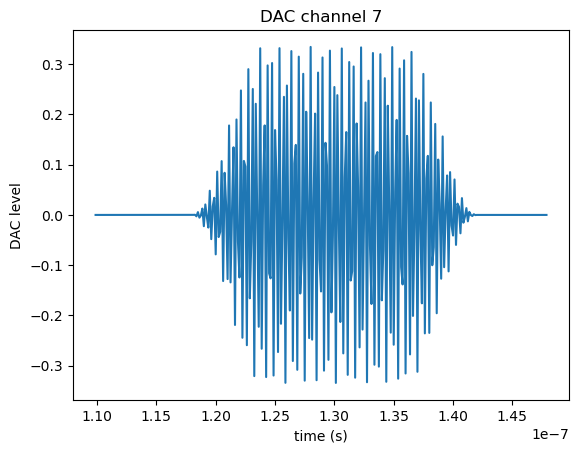

In [10]:
# plot the output of DAC channel 7, from t = 110 ns to t = 150 ns (relative to the start of the simulation)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 150.e-9)

You probably noticed that the pulse starts \~115 ns *after* the start of the simulation, even though it is scheduled to play immediately. Most of this latency (~100 ns) comes from synthesizing the pulse itself, while some is from the program initialization (e.g. issuing resets, initial triggers, etc)

# Multiple Pulses

Multiple pulses on the same channel are played **sequentially**. Pulses on separate channels are scheduled in parallel; i.e. **each pulse is played as soon as it's output channel is available**. 

## Two consecutive pulses on the same channel

In [11]:
circuit = [
    #play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}
    
]

In [12]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [13]:
client.run_program(asm_prog, sim_time=200.e-9)

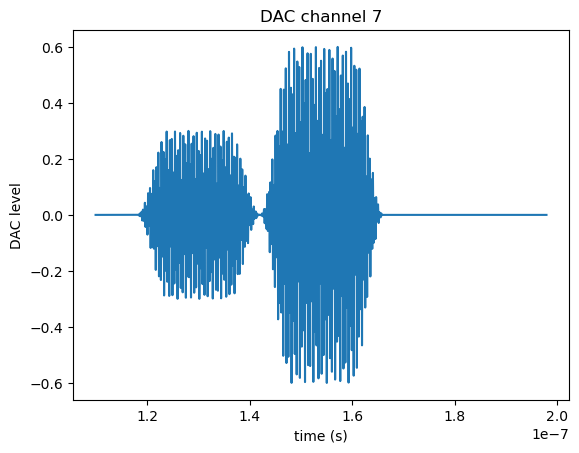

In [14]:
client.plot_dac_out(7, 110.e-9, 200.e-9)

## Add a pulse on a different channel

In [15]:
circuit = [
    # play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'},
    
    # add a single pulse on Q1 drive -- this will be scheduled immediately, and played in parallel with the first Q0 pulse
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'}
    
]

In [16]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [17]:
client.run_program(asm_prog, sim_time=200.e-9)

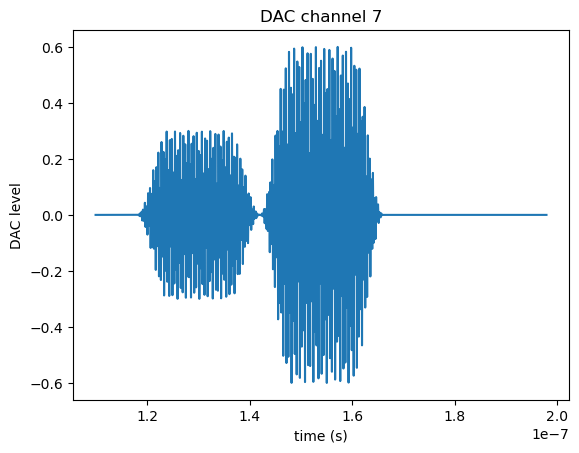

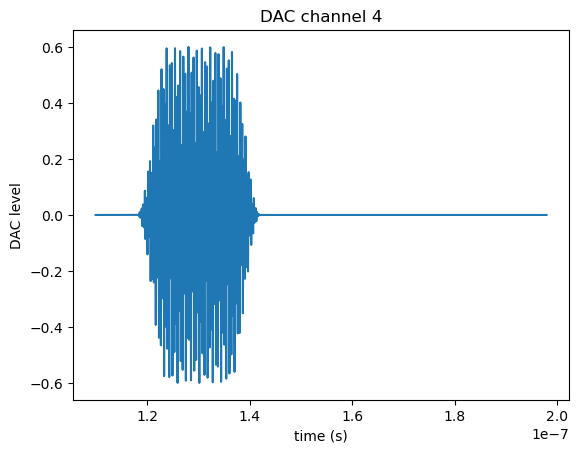

In [18]:
# do it yourself?
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 200.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 200.e-9) #maybe add subplots?

### Timing Constraints

Delays and barriers can be used to control when pulses are played relative to one another:
  - `delay`: delay subsequent pulses on all channels in `scope` by amount `t` (in seconds). If `scope` is not provided, delay all channels
  - `barrier`: insert a scheduling barrier that applies to all channels in `scope`. All subsequent pulses on those channels are scheduled to play after the last pulse before the barrier (on those same channels) has finished (this is very similar to the behavior of a barrier in Qiskit). As with the `delay` instruction, if no channels are provided in `scope`, the barrier is applied to all channels.


In [12]:
circuit = [
    #play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'delay', 't': 50.e-9},
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'},
    
    {'name': 'barrier'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'}
    
]

*Compile, run, and plot the output below:*

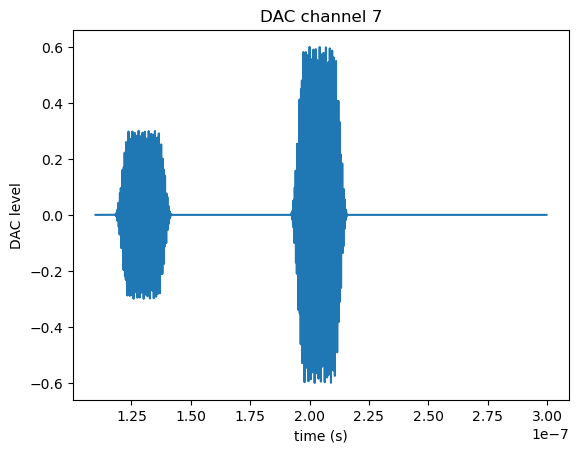

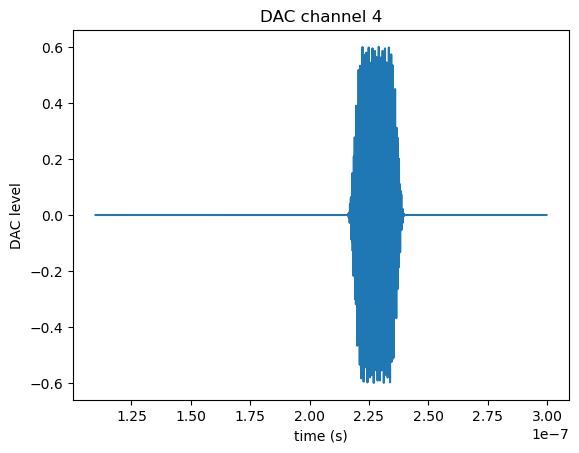

In [13]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
client.run_program(asm_prog, sim_time=500.e-9)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 300.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 300.e-9) #maybe add subplots?

#### Extra: Scoped Delays and Barriers

Delays and barriers can be scoped to a subset of channels using the `scope` field (e.g. `{'name': 'barrier', 'scope': ['Q0', 'Q2']}`). Try to generate a pulse sequence with the following structure:

In [28]:
#key-only

circuit = [
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'},
    
    {'name': 'barrier', 'scope': ['Q0.qdrv', 'Q1.qdrv']}, # scope: ['Q0, 'Q1'] also works
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'},
    
    {'name': 'barrier', 'scope': ['Q1.qdrv', 'Q2.qdrv']},
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.qdrv'}]
    
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
client.run_program(asm_prog, sim_time=500.e-9)

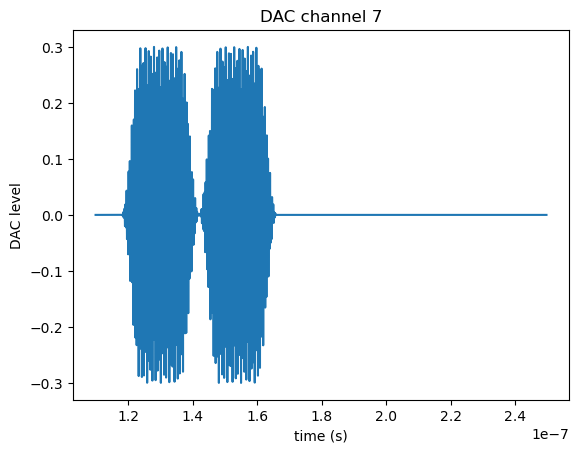

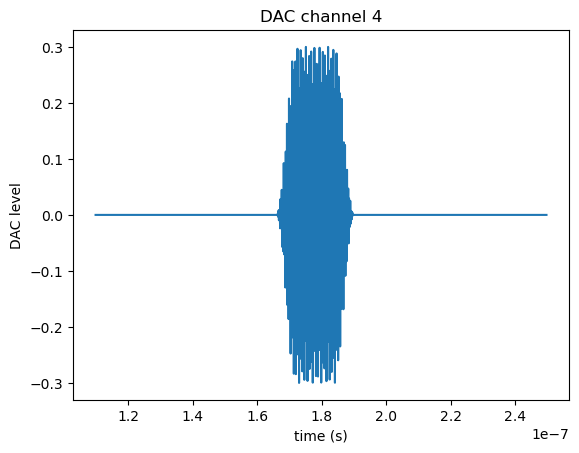

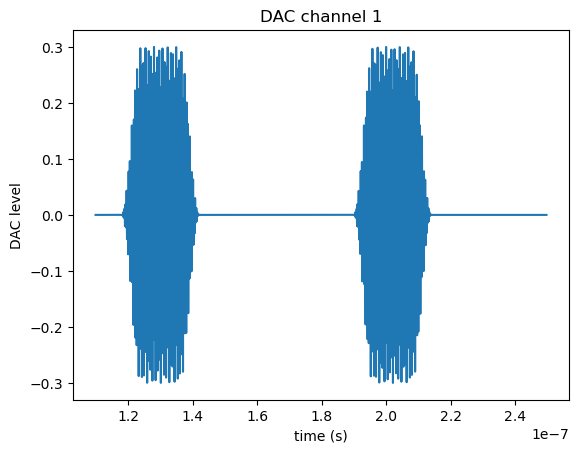

In [29]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 250.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 250.e-9)
client.plot_dac_out(channel_configs['Q2.qdrv'].core_ind, 110.e-9, 250.e-9)

# Gates

Calibrated gate information can be stored in a json file (example: qubitcfg.json) and referenced in QubiC circuits. Each gate consists of a list of a list of pulses

## Example of X90 gate on Q0

## Example of CNOT gate, consisting of a composite list of pulses

In [21]:
circuit = [
    # this circuit plays calibrated X90 gates
    {'name': 'X90', 'qubit': 'Q0'},
    {'name': 'X90', 'qubit': 'Q1'}]

In [6]:
# load in configuration from qubitcfg.json
qchip = qc.QChip('qubitcfg.json')

In [7]:
# inspect a gate
qchip.gates['Q0X90'].cfg_dict

[{'freq': 'Q0.freq',
  'phase': 0.0,
  'dest': 'Q0.qdrv',
  'twidth': 2.4e-08,
  't0': 0.0,
  'amp': 0.11222212331696187,
  'env': [{'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25}}]}]

In [23]:
# link the qchip configuration at compile time
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)

Finish the assembly stage below and plot the dac outputs:

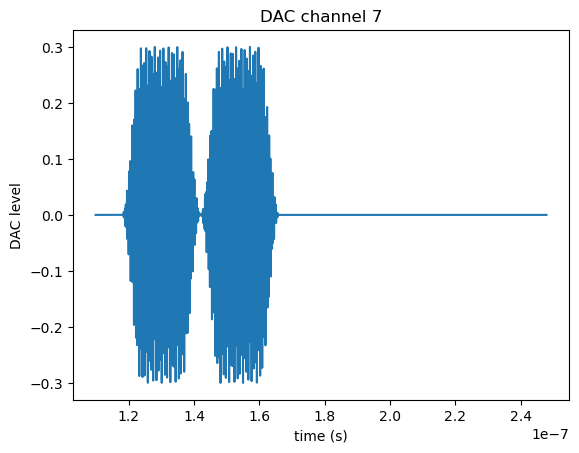

In [30]:
# key-only
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
client.run_program(asm_prog, sim_time=250.e-9)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 250.e-9)

# Readout

The qubit readout signal chain has two phases:
 1. Using the readout DAC to play a **drive pulse** that excites the readout resonator
 2. Recording the response using the **readout ADC**, and measuring the the change in resonator frequency (hence qubit state) using **digital IQ downconversion**
 
## Readout Drive

The readout drive signal path looks like this:

![image](images/dac_signal_path.drawio.svg)

As you might have guessed from the diagram, the readout chain is **frequency multiplexed**. That is, a bank of **8 independent firmware signal generators** can be used to drive the readout DAC, which allows **8 qubits to be read out simultaneously** (provided their readout resonators are coupled to a common bus). Readout pulses can be scheduled and parameterized like any other pulse.

**Note**: As with the previous demo we don't have a physical DAC, so the readout drive maps to `dac_out[8]`

### Play a pulse on the readout drive channel

Pulses can be played on readout drive channels by setting the `dest` field to `Qn.rdrv`. In the channel configuration, this corresponds to a `core_ind` that is the same as the drive channel for that qubit, and `elem_ind = 1`.

In [36]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6.1e9, 'amp': 0.6, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdrv'}]

In [37]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [38]:
client.run_program(asm_prog, sim_time=500.e-9)

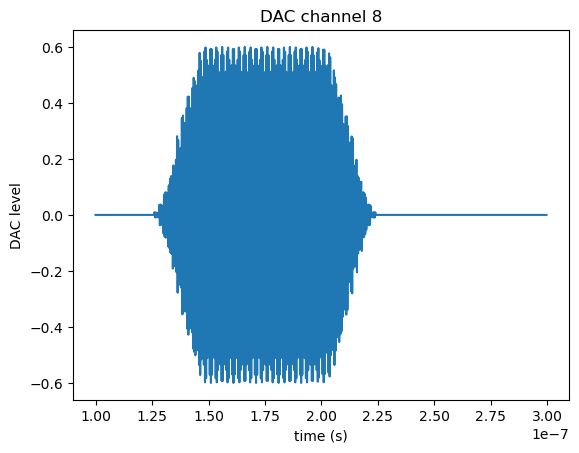

In [39]:
client.plot_dac_out(8, 100.e-9, 300.e-9)

Now try it with multiple readout pulses on different qubits. Note that readout pulses are arbitrary/can be optimized per qubit.

In [35]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6.1e9, 'amp': 0.4, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdrv'},
           {'name': 'pulse', 'phase': 0, 'freq': 6.2e9, 'amp': 0.4, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.rdrv'}]

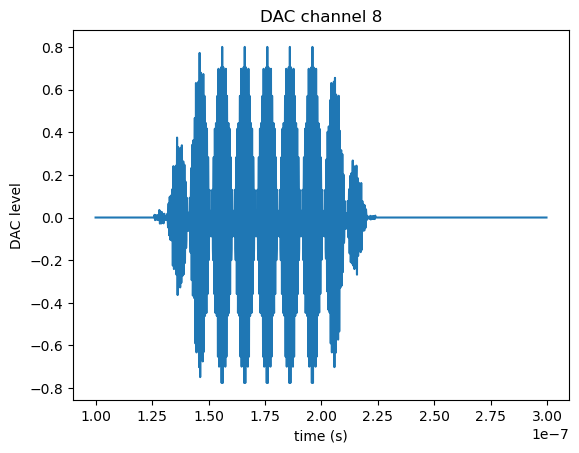

In [36]:
## compile, assemble and plot here. When plotting, try zooming in to a small time range to see the different frequency components
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

client.run_program(asm_prog, sim_time=500.e-9)
client.plot_dac_out(8, 100.e-9, 300.e-9)

Text(0.5, 0, 'freq (Hz)')

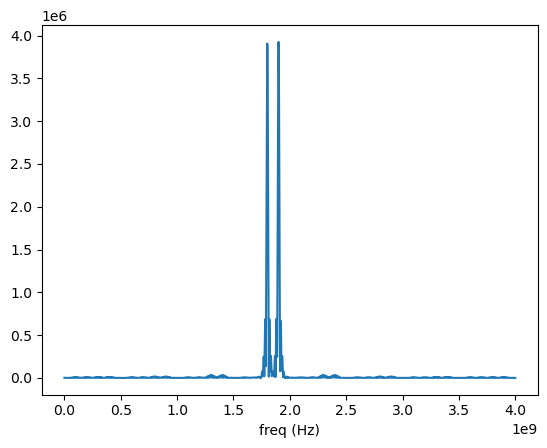

In [46]:
# If we plot an FFT of the above signal we can see both frequency components:
fftfreq = np.fft.rfftfreq(len(client.dac_out[8]), 0.125e-9)
rdrv_fft = np.fft.rfft(client.dac_out[8])
plt.plot(fftfreq, np.abs(rdrv_fft))
plt.xlabel('freq (Hz)')

**Note**: The peaks we see here are the *image frequencies* in the first nyquist zone (0 - 4 GHz), reflected across the nyquist frequency of 4 GHz (`f_image = f_nyquist - (f - f_nyquist)`). With appropriate configuration of DACs and choice of filter, these images can be attenuated, leaving the tones in the second nyquist zone (4 - 8 GHz).

## Readout Demodulation

The firmware also has **8 signal generator channels** for generating **readout demodulation tones** (these are called **readout_demod** or **rdlo** channels, for readout local-oscillator). These demodulation tones are **mixed with the signal from the readout ADC** to downconvert that readout tone to baseband. The full readout demodulation signal path looks like this:

![image](images/readout_chain.drawio.svg)

Note the accumulators after the mixing stage. Any pulse on a readout_demod (rdlo) channel will **reset and trigger the corresponding accumulator**, which will integrate the mixed signal for the duration of the rdlo pulse.

Generate a pulse on an RDLO channel, and plot the signal:

In [43]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6100.e6, 'amp': 0.6, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdlo'}] # maybe add example at 6.5, at least make consistent with DAC

compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [44]:
client.run_program(asm_prog, sim_time=500.e-9, capture_demod=True) #run the program, and tell the simulator to store the demod signals

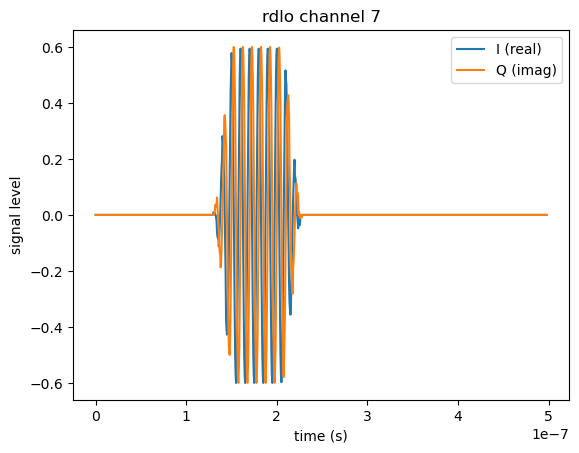

In [45]:
client.plot_rdlo(channel_configs['Q0.rdlo'].core_ind, 0)

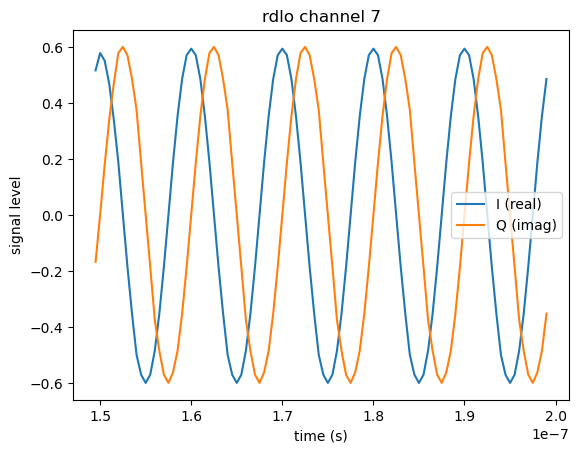

In [121]:
client.plot_rdlo(channel_configs['Q0.rdlo'].core_ind, 150.e-9, 200.e-9)

We can also use the simulator to plot the signal after mixing with the ADC:

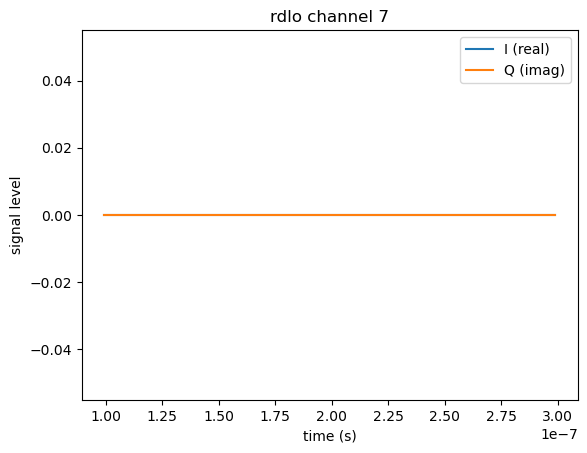

In [122]:
client.plot_rdlo_x_adc(channel_configs['Q0.rdlo'].core_ind, 100.e-9, 300.e-9)

The mixed signal is 0, since there's no input to the ADC. 

Let's add an ADC stream:

In [46]:
adc_dt = 0.5e-9 # ADC sample rate is 2 GHz
freq = 6100.e6 # we want to frequency-match the RDLO pulse to properly downconvert to baseband

adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(1000)) #create a 1000 sample stream

client.run_program(asm_prog, sim_time=500.e-9, capture_demod=True, adc_stream=adc_stream)

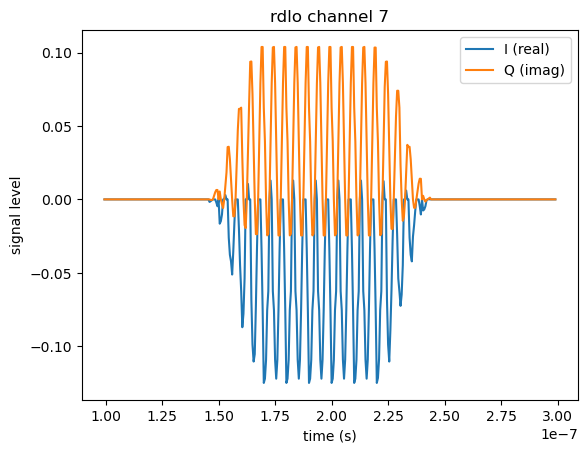

In [47]:
# point out undersampled ADC + lack of analog mixing
client.plot_rdlo_x_adc(channel_configs['Q0.rdlo'].core_ind, 100.e-9, 300.e-9)

### Accumulated Signal

The accumulated (integrated) downconverted signal is available from the simulator client:

In [125]:
client.acc

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([780923.-1074277.j])]

In the real hardware, these values are saved to a memory buffer that can be read by the host PC

# Branching/Feedforward using Mid-circuit Measurements 

QubiC is capable of making arbitrary real-time control decisions based on measurement results. The latency of these operations (~200-300 ns todo: put where this comes from) is well within the coherence time of superconducting transmon qubits . The distributed processor cores make branching decisions by interacting with a firmware module called the "function processor" (FPROC):

![image](images/qubic_arch.png)

Depending on the implementation, the FPROC can **aggregate measurement results**, or optionally do some **application specific data processing**. Each distributed processor **core** can **request/receive results** from the FPROC using a special instruction. In the current implementation for this simulation, the FPROC simply aggregates thresholded measurement results.

## `branch_fproc` Instruction

The instruction used for **branching** looks like this:

```json
{'name': 'branch_fproc', 'alu_cond': <'le' or 'ge' or 'eq'>, 'cond_lhs': <var or ival>, 
'func_id': function_id, 'scope': <list_of_qubits_or_channels> 'true': [instruction_list], 'false': [instruction_list]}
```

Let's break this down:
 1. Data is **requested** from the FPROC according to the provided `func_id`. In the version of the gateware we're simulating, `func_id` just indicates the qubit whose measurement result we want. A list of available FPROC channels can be found in `fpga_config.fproc_channels`
 2. Once the FPROC receives the request, it **waits** for the **next available measurement** on that channel and sends it to the **core(s)** that requested it
 3. The **core** makes a **branching decision** according to `cond_lhs <alu_cond> fproc_result`. For example, you can check if the measurement was 0 using: `cond_lhs = 0`, `alu_cond = 'eq'`, which implements: `0 == fproc_result`.
 4. If the expression evaluates to **True**, the block of instructions in the `true` field are executed, **else** the block in `false` is executed.

## A note about state classification/thresholding

The FPROC classsifies states by thresholding across the y-axis; any accumulated value with `x>0` gets classified to 0; `x<0` goes to 1. Future FPROC implementations will include custom thresholds and qutrit states.

![image](images/reset_image.svg)

## FPROC Channels

A list of available FPROC channels in the current gateware can be found in `fpga_config.fproc_channels`:

In [20]:
fpga_config.fproc_channels

{'Q0.meas': FPROCChannel(id=('Q0.rdlo', 'core_ind'), delay=1.5e-07),
 'Q1.meas': FPROCChannel(id=('Q1.rdlo', 'core_ind'), delay=1.5e-07),
 'Q2.meas': FPROCChannel(id=('Q2.rdlo', 'core_ind'), delay=1.5e-07),
 'Q3.meas': FPROCChannel(id=('Q3.rdlo', 'core_ind'), delay=1.5e-07),
 'Q4.meas': FPROCChannel(id=('Q4.rdlo', 'core_ind'), delay=1.5e-07),
 'Q5.meas': FPROCChannel(id=('Q5.rdlo', 'core_ind'), delay=1.5e-07),
 'Q6.meas': FPROCChannel(id=('Q6.rdlo', 'core_ind'), delay=1.5e-07),
 'Q7.meas': FPROCChannel(id=('Q7.rdlo', 'core_ind'), delay=1.5e-07)}

Each named channel indexes a `FPROCChannel` object, which contains the physical channel `id` to use, as well as the additional `delay` required to access the measurement (i.e. the additional delay, after the measurement pulse, required before the pulse is available).

The channel `id` is resolved by the assembler using the `channel_configs` object; e.g. for `Q0.meas`, the physical channel ID is given by `channel_configs['Q0.rdlo'].core_ind`.

The delay is used by the scheduler to ensure that all subsequent pulses are scheduled **after** the measurement becomes available.

## Circuit with Branching

Branch statements are a valid instruction type, and can be included in circuits

In [36]:
circuit = [
    {'name': 'read', 'qubit': 'Q0'}, #use a read gate, which includes an rdrv pulse followed by an rdlo pulse
    {'name': 'branch_fproc', 'alu_cond': 'eq', 'cond_lhs': 0, 'func_id': 'Q0.meas', 'scope': ['Q0'], 
     'true': [
         {'name': 'X90', 'qubit':'Q0'}], 
     'false': []}]


In [37]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

The compiler lowers **branch statements** to **conditional jumps** that execute on the distributed processor core:

In [38]:
compiled_prog.program

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 0.0,
   'amp': 0.01967670502549965,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 5,
   'dest': 'Q0.rdrv'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 1.4806632895920675,
   'amp': 1.0,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 305,
   'dest': 'Q0.rdlo'},
  {'op': 'jump_fproc',
   'in0': 0,
   'alu_op': 'eq',
   'jump_label': 'true_0',
   'func_id': ('Q0.rdlo', 'core_ind')},
  {'op': 'jump_label', 'dest_label': 'false_0'},
  {'op': 'jump_i', 'jump_label': 'end_0'},
  {'op': 'jump_label', 'dest_label': 'true_0'},
  {'op': 'pulse',
   'freq': 4460029188.07884,
   'phase': 0.0,
   'amp': 0.11222212331696187,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start

In [11]:
# Define an ADC stream

adc_dt = 0.5e-9 # ADC sample rate is 2 GHz
freq = 6100.e6 # we want to frequency-match the RDLO pulse to properly downconvert to baseband

adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000)) #create a 5000 sample stream

In [40]:
# run the program, and check the acc result
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream)

In [41]:
client.acc

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([-39439124.-34540748.j])]

The accumulated result has a real part <0, so we expect no pulses on the qdrv channel:

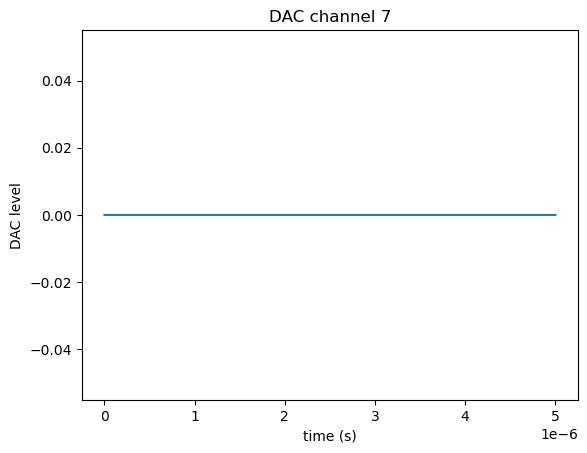

In [42]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind)

Let's phase shift the ADC stream by 180 degrees to flip the sign of the downconverted value:

In [43]:
adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000) + np.pi) #create a 5000 sample stream
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream)
client.acc

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([39422450.+34437449.j])]

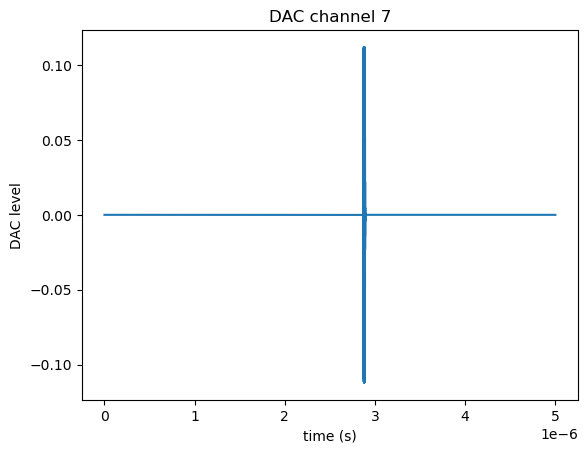

In [44]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) # check for the pulse out

Branching is fully general -- try writing a program that executes a pulse sequence on Q2 based on a Q0 measurement result. Note that the conditionally executed pulse sequence can consist of pulses AND readouts.

In [20]:
## insert code/plots here
# key-only
circuit = [
    {'name': 'read', 'qubit': 'Q0'}, #use a read gate, which includes an rdrv pulse followed by an rdlo pulse
    {'name': 'branch_fproc', 'alu_cond': 'eq', 'cond_lhs': 0, 'func_id': 'Q0.meas', 'scope': ['Q0', 'Q2'], 
     'true': [
         {'name': 'X90', 'qubit':'Q2'}], 
     'false': [
         {'name': 'X90', 'qubit':'Q2'},
         {'name': 'X90', 'qubit':'Q2'},
         {'name': 'X90', 'qubit':'Q0'}
     ]}]

compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 0.0,
   'amp': 0.01967670502549965,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 5,
   'dest': 'Q0.rdrv'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 1.4806632895920675,
   'amp': 1.0,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 305,
   'dest': 'Q0.rdlo'},
  {'op': 'jump_fproc',
   'in0': 0,
   'alu_op': 'eq',
   'jump_label': 'true_0',
   'func_id': ('Q0.rdlo', 'core_ind')},
  {'op': 'jump_label', 'dest_label': 'false_0'},
  {'op': 'pulse',
   'freq': 4460029188.07884,
   'phase': 0.0,
   'amp': 0.11222212331696187,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 1380,
   'dest': 'Q0.qdrv'},
  {'op': 'jump_i', 'jump_label': 'end_0'},
  {'op': 'j

In [12]:
adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000) + np.pi) #create a 5000 sample stream
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream)
client.acc

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([39422450.+34437449.j])]

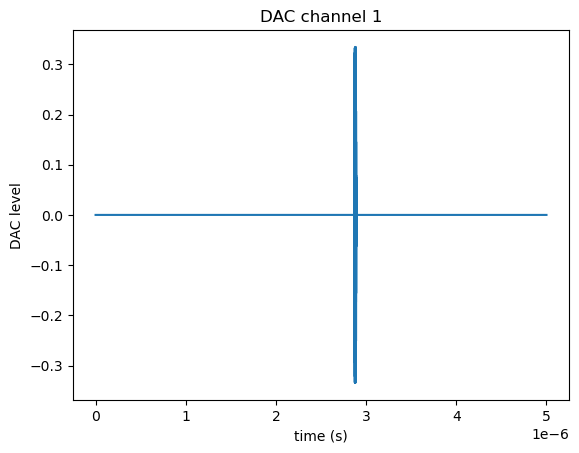

In [13]:
client.plot_dac_out(channel_configs['Q2.qdrv'].core_ind)

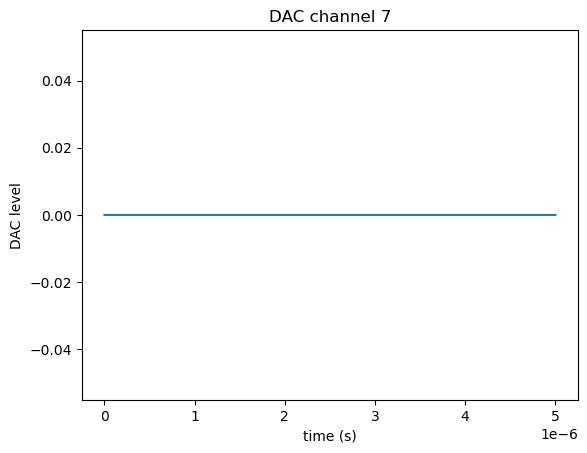

In [15]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind)

In [16]:
# try the other branch
adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000)) #create a 5000 sample stream
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream)
client.acc

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([-39439124.-34540748.j])]

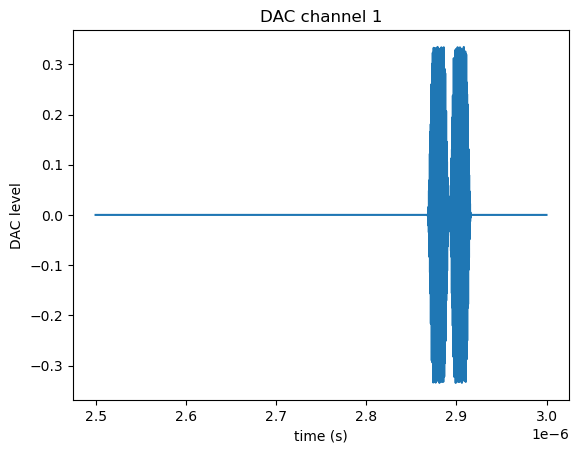

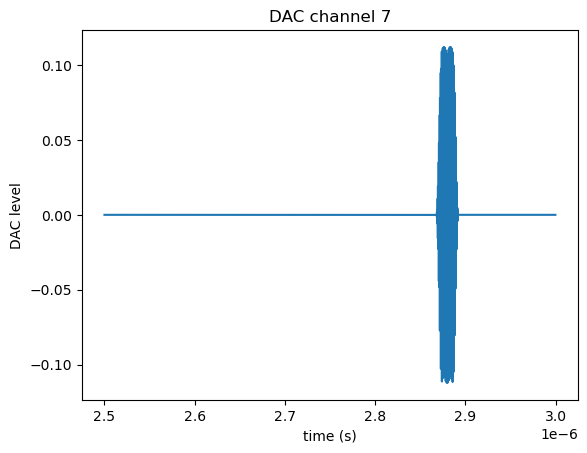

In [19]:
client.plot_dac_out(channel_configs['Q2.qdrv'].core_ind, 2.5e-6, 3.e-6)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 2.5e-6, 3.e-6)

# Loops

The loop instruction can be used to repeat pulse sequences in hardware, with minimal latency:

```json
{'name': 'loop', 'cond_lhs': <reg or ival>, 'alu_cond': <'ge', 'le', 'eq'>, 'cond_rhs': var_name, 'scope': <list_of_qubits>, 'body': [instruction_list]}
```
This instruction will execute the instruction list in `'body'` while the condition specified in the loop instruction (`cond_lhs <alu_cond> cond_rhs)` evaluates to true. To use loops effectively, we also introduce instructions that declare and operate on **variables**

## `declare` Instruction

```json
{'name': 'declare', 'var': <var_name>, 'scope': <list_of_qubits_or_channels>, 'type': <'phase' or 'amp' or 'int'>}
```
Declares a variable `var_name`. The `scope` is a list of qubits or channels that might reference the variable; for example if the variable was a loop index over qubit drive operations on Q1 and Q0, you could set `scope: ['Q0', 'Q1']` or `scope: ['Q0.qdrv', 'Q1.qdrv']`. `type` is optional and defaults to `'int'`, which is used for general purpose operations. `'phase'` and `'amp'` are types used for register-based pulse parameterization.

## `set_var` Instruction

```json
{'name': 'set_var', 'value': <value>, 'var': <var_name>}
```
This instruction simply sets the value of `var_name` to `value`

## `alu_op` Instruction

```json
{'name': 'alu', 'op': 'add' or 'sub' or 'le' or 'ge' or 'eq', 'lhs': var_name or value, 'rhs': var_name, 'out': output reg}
```

Performs a binary operation and stores it in a variable. The inputs to the operation are given by `lhs` and `rhs`. `lhs` can be an immediate value or register, and `rhs` must be a variable. Result is stored in `out` (can be the same as `lhs` and/or `rhs`).


In [25]:
# repeat a Q0 drive pulse 10 times:
circuit = [
    {'name': 'declare', 'var': 'loop_ind', 'scope': ['Q0']},
    {'name': 'set_var', 'value': 0, 'var': 'loop_ind'},
    #{'name': 'delay', 't': 10.e-9},
    {'name': 'loop', 'cond_lhs': 10, 'alu_cond': 'ge', 'cond_rhs': 'loop_ind', 'scope': ['Q0'], 
     'body': [
         {'name': 'X90', 'qubit': 'Q0'},
         {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'loop_ind', 'out': 'loop_ind'}
     ]}]

In [26]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program

Z-phase resolution inside loops not supported, be careful!


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'declare_reg', 'name': 'loop_ind', 'dtype': 'int'},
  {'op': 'reg_alu',
   'in0': 0,
   'in1_reg': 'loop_ind',
   'alu_op': 'id0',
   'out_reg': 'loop_ind'},
  {'op': 'jump_label', 'dest_label': 'loop_0_loopctrl'},
  {'op': 'pulse',
   'freq': 4460029188.07884,
   'phase': 0.0,
   'amp': 0.11222212331696187,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 10,
   'dest': 'Q0.qdrv'},
  {'op': 'reg_alu',
   'in0': 1,
   'in1_reg': 'loop_ind',
   'alu_op': 'add',
   'out_reg': 'loop_ind'},
  {'op': 'inc_qclk', 'in0': -24},
  {'op': 'jump_cond',
   'in0': 10,
   'alu_op': 'ge',
   'jump_label': 'loop_0_loopctrl',
   'in1_reg': 'loop_ind'},
  {'op': 'done_stb'}]}

In [10]:
client.run_program(asm_prog, sim_time=1.e-6)

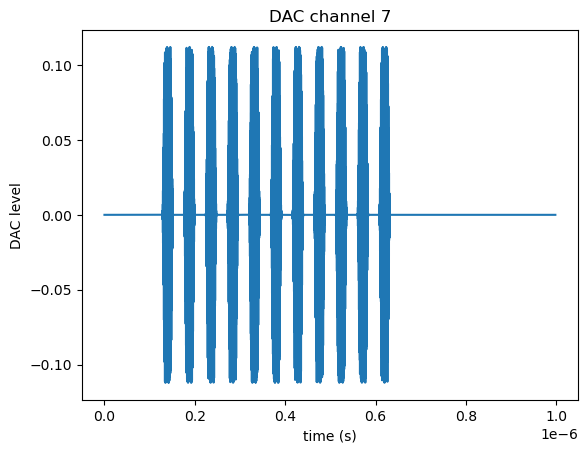

In [11]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind)

## Example Fast Amplitude Sweep

In [40]:
# sweep Q0.drive amplitude:
circuit = [
    {'name': 'declare', 'var': 'loop_ind', 'scope': ['Q0']},
    {'name': 'set_var', 'value': 0, 'var': 'loop_ind'},
    {'name': 'declare', 'var': 'amp', 'scope': ['Q0'], 'dtype': 'amp'},
    {'name': 'set_var', 'value': 0.1, 'var': 'amp'}, # pulse amplitude is parameterized by processor register
    {'name': 'loop', 'cond_lhs': 9, 'alu_cond': 'ge', 'cond_rhs': 'loop_ind', 'scope': ['Q0'], 
     'body': [
            {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 'amp', 'twidth': 2.4e-08,
             'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
             'dest': 'Q0.qdrv'},
         {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'loop_ind', 'out': 'loop_ind'},
         {'name': 'alu', 'op': 'add', 'lhs': 0.1, 'rhs': 'amp', 'out': 'amp'}

         
     ]}]

In [38]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program

Z-phase resolution inside loops not supported, be careful!


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'declare_reg', 'name': 'loop_ind', 'dtype': 'int'},
  {'op': 'reg_alu',
   'in0': 0,
   'in1_reg': 'loop_ind',
   'alu_op': 'id0',
   'out_reg': 'loop_ind'},
  {'op': 'declare_reg', 'name': 'amp', 'dtype': ('amp', 0)},
  {'op': 'reg_alu',
   'in0': 0.1,
   'in1_reg': 'amp',
   'alu_op': 'id0',
   'out_reg': 'amp'},
  {'op': 'jump_label', 'dest_label': 'loop_0_loopctrl'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 'amp',
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 15,
   'dest': 'Q0.qdrv'},
  {'op': 'reg_alu',
   'in0': 1,
   'in1_reg': 'loop_ind',
   'alu_op': 'add',
   'out_reg': 'loop_ind'},
  {'op': 'reg_alu',
   'in0': 0.1,
   'in1_reg': 'amp',
   'alu_op': 'add',
   'out_reg': 'amp'},
  {'op': 'inc_qclk', 'in0': -34},
  {'op': 'jump_cond',
   'in0': 9,
   'alu_op': 'ge',
   'jump_label': 'loop_0_loopctrl',
   'in1_r

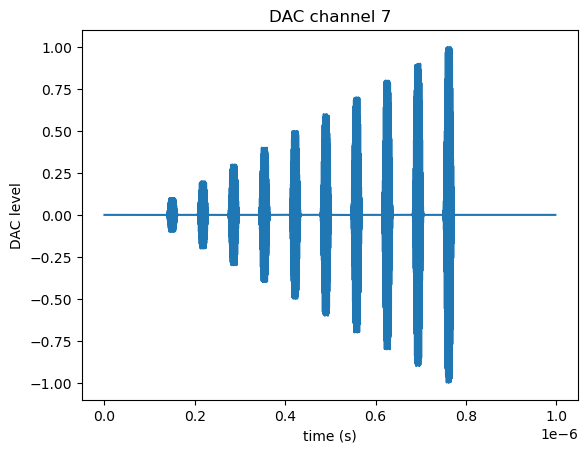

In [39]:
client.run_program(asm_prog, sim_time=1.e-6)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind)